In [1]:
state = 'WV' 
year = 2010
objective_types = ['cut_edges', 'perimeter', 'inverse_Polsby_Popper', 'average_Polsby_Popper', 'bottleneck_Polsby_Popper']
starting_deviation = 0.01 

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of WV has 3 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))
from WV_plans_2010 import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 1575 plans from file.


In [6]:
#County-level districts for enacted map in 2000 
similarity_initial_districts = [[0, 2, 3, 4, 5, 10, 11, 13, 16, 17, 24, 26, 31, 32, 33, 35, 45, 48, 49], [6, 12, 14, 18, 20, 21, 22, 23, 27, 28, 29, 30, 37, 39, 41, 44, 47, 50, 51, 52], [1, 7, 8, 9, 15, 19, 25, 34, 36, 38, 40, 42, 43, 46, 53, 54]]
similarity_threshold = 1746094

In [7]:
#create a dictionary mapping each node to its Census 2000 population
filename3 = '../../dat/' + str(year) +'/WV_2000_Census_population.csv'

county_to_population = {}

with open(filename3, 'r') as file:
    next(file)  # Skip the first header row
    next(file)  # Skip the second row
    county_to_population = {
        str(line.split(',')[0]).strip(): int(line.split(',')[6])  # Column 0: County Name, Column 6: Census 2000 Population
        for line in file
    }

In [8]:
# map the population values to nodes based on the county name
pop_by_node = {i: None for i in G.nodes}

for i in G.nodes:
    county_name = str(G.nodes[i].get('NAME10')).strip() 
    if county_name in county_to_population:
        pop_by_node[i] = county_to_population[county_name]
    else:
        pop_by_node[i] = None

In [9]:
import networkx as nx
nx.set_node_attributes(G, pop_by_node, "TOTPOP2000")

In [10]:
from epsilon_constraint import epsilon_constraint_method
from pareto import filter_and_sort_pareto
from metrics import scores

plans_dict = {}
for obj_type in objective_types:
    
    print(f"\n{'#' * 100}")
    print(f"Applying epsilon-constraint method for {state} with compactness objective {obj_type}")
    print(f"{'#' * 100}\n")
    
    plans_scores = [scores(G, plan, G._ideal_population, obj_type) for plan in warm_starts]
    _,_,nondominated_warm_starts_plans = filter_and_sort_pareto(plans=warm_starts, upper_bounds=plans_scores, obj_type=obj_type)
    print(f"Passing {len(nondominated_warm_starts_plans)} nondominated warm start plans")
    
    (new_plans, obj_bounds, deviations) = epsilon_constraint_method(
                G,                 
                obj_type,          
                contiguity ='lcut',                                          # {'lcut', 'scf', 'shir'} 
                cutoff=None,       
                verbose=True,
                warm_start_mode =None,                                        # {'None', 'user', 'refinement'}
                warm_starts=None,                                             # if you have user define warm starts else it is None
                starting_deviation=starting_deviation, 
                time_limit=3600, 
                sizes=None,      
                max_B=False,                                                 # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True   
                symmetry_breaking= None,                                    # {None, 'orbitope', 'rsum'} 
                state=state,
                year=year, 
                similarity = [similarity_initial_districts,similarity_threshold]
            )
    plans_dict[(state, obj_type)] = list(zip(new_plans, obj_bounds, deviations))
    warm_starts += new_plans


####################################################################################################
Applying epsilon-constraint method for WV with compactness objective cut_edges
####################################################################################################

Passing 12 nondominated warm start plans
Initially, L = 611489 and U = 623841 and k = 3.

****************************************
Trying deviation = 6176.6466666666665
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 611489 and U = 623841 and k = 3
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1, 1]
Set parameter LazyConstraints to value 1
Set parameter FeasibilityTol to value 1e-07
Set parameter IntFeasTol to value 1e-07
Set parameter MIPGap to value 1e-07
Set parameter TimeLimit to

Model fingerprint: 0x67885345
Variable types: 0 continuous, 1330 integer (1330 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve removed 660 rows and 328 columns
Presolve time: 0.02s
Presolved: 852 rows, 1002 columns, 2997 nonzeros
Variable types: 0 continuous, 1002 integer (1002 binary)

Root relaxation: objective 2.950646e+01, 378 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.50646    0  100          -   29.50646      -     -    0s
     0     0   34.15681    0   91          -   34.15681      -     -    0s
     0     0   36.89676    0  152          -   36.89676      -     -    0s
     0     0   37.02754    0  155          -   37.02754      -     -    0s
     0     0 infeasible    0               

Final county-level districts for Enacted Plan is:
[[6, 14, 21, 22, 23, 27, 28, 29, 30, 37, 39, 41, 44, 47, 50, 51, 52], [1, 7, 8, 9, 12, 15, 18, 19, 25, 34, 36, 38, 40, 42, 43, 46, 53, 54], [0, 2, 3, 4, 5, 10, 11, 13, 16, 17, 20, 24, 26, 31, 32, 33, 35, 45, 48, 49]]
Deviation for 'Enacted Plan': 3197.333333333372
Objective values for 'Enacted Plan': {'cut_edges': 34}


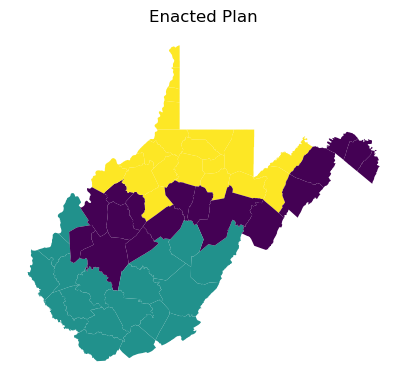

Final county-level districts for Facemire Plan is:
[[2, 4, 6, 11, 14, 16, 17, 20, 28, 29, 30, 31, 32, 41, 44, 48, 49, 50, 51], [1, 7, 8, 9, 12, 15, 18, 19, 25, 34, 36, 38, 40, 42, 43, 46, 53, 54], [0, 3, 5, 10, 13, 21, 22, 23, 24, 26, 27, 33, 35, 37, 39, 45, 47, 52]]
Deviation for 'Facemire Plan': 1523.6666666666279
Objective values for 'Facemire Plan': {'cut_edges': 27}


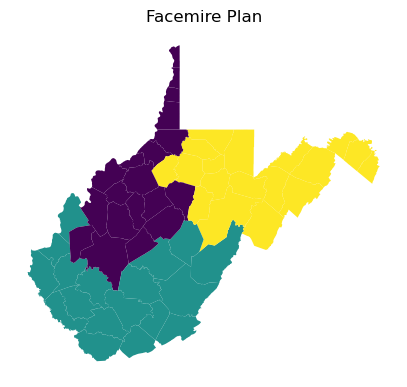

Final county-level districts for Cooper Plan 1 is:
[[0, 2, 4, 6, 11, 14, 16, 17, 18, 20, 25, 29, 30, 31, 32, 38, 41, 48, 49, 50], [3, 5, 7, 9, 10, 13, 21, 22, 23, 24, 26, 27, 33, 35, 37, 39, 42, 45, 46, 47, 51, 52, 54], [1, 8, 12, 15, 19, 28, 34, 36, 40, 43, 44, 53]]
Deviation for 'Cooper Plan 1': 323.66666666662786
Objective values for 'Cooper Plan 1': {'cut_edges': 34}


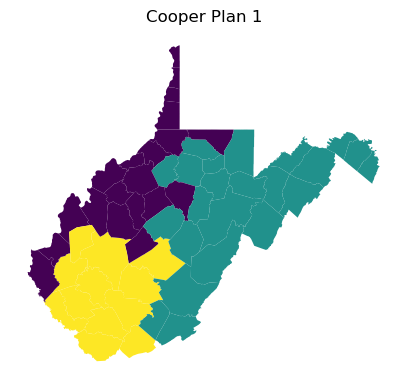

Final county-level districts for Cooper Plan 2 is:
[[5, 6, 7, 9, 10, 14, 18, 20, 25, 29, 30, 31, 35, 38, 41, 42, 46, 48, 50, 51, 52, 54], [1, 8, 12, 15, 19, 28, 34, 36, 40, 43, 44, 53], [0, 2, 3, 4, 11, 13, 16, 17, 21, 22, 23, 24, 26, 27, 32, 33, 37, 39, 45, 47, 49]]
Deviation for 'Cooper Plan 2': 232.66666666662786
Objective values for 'Cooper Plan 2': {'cut_edges': 36}


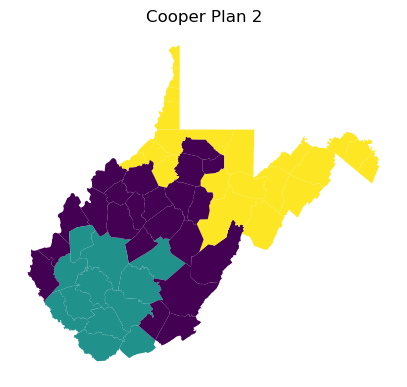

Final county-level districts for Cooper Plan 3 is:
[[5, 7, 9, 10, 12, 15, 19, 20, 29, 30, 34, 35, 36, 40, 42, 43, 46, 51, 52, 53, 54], [1, 6, 8, 14, 18, 25, 28, 31, 38, 41, 44, 48, 50], [0, 2, 3, 4, 11, 13, 16, 17, 21, 22, 23, 24, 26, 27, 32, 33, 37, 39, 45, 47, 49]]
Deviation for 'Cooper Plan 3': 115.66666666662786
Objective values for 'Cooper Plan 3': {'cut_edges': 35}


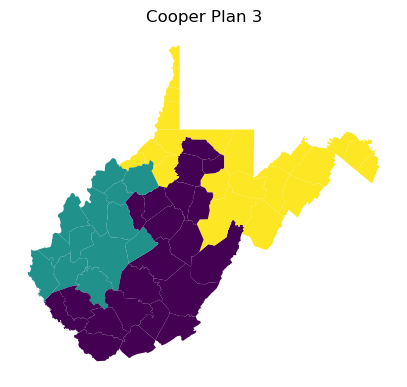

In [11]:
# Special plans
from metrics import county_level_districts, compute_obj, observed_deviation_persons
from draw import draw_plan
import math

special_plans = ['Enacted Plan','Facemire Plan','Cooper Plan 1','Cooper Plan 2','Cooper Plan 3']
special_plans_scores = {}
G_copy = G.copy()
G_copy._k = G._k
G_copy._ideal_population = G._ideal_population

for plan_name in special_plans:
            
    districts = county_level_districts(G_copy, plan_name, G_copy._k)
    print(f"Final county-level districts for {plan_name} is:")
    print(districts)
    
    deviation = observed_deviation_persons(G_copy, districts, G_copy._ideal_population)
    G_copy._L = math.ceil(G_copy._ideal_population - deviation)
    G_copy._U = math.floor(G_copy._ideal_population + deviation)
    
    scores = {obj: round(compute_obj(G_copy, districts, obj), 4) for obj in objective_types}
    special_plans_scores[plan_name] = [deviation, scores]
    
    print(f"Deviation for '{plan_name}': {deviation}")
    print(f"Objective values for '{plan_name}': {scores}")

    draw_plan(filepath, filename2, G_copy, districts, title=plan_name, year=year)

No feasible solution was found within the region: [0, 1673.7]

####################################################################################################
Pareto Frontier for state WV,  objective cut_edges
####################################################################################################

Pareto front plans: [[[0, 2, 3, 4, 5, 10, 11, 13, 16, 17, 20, 24, 26, 31, 32, 33, 35, 45, 48, 49], [6, 12, 14, 18, 21, 22, 23, 27, 28, 29, 30, 37, 39, 41, 47, 50, 51, 52], [1, 7, 8, 9, 15, 19, 25, 34, 36, 38, 40, 42, 43, 44, 46, 53, 54]]]
Pareto front upper bounds: [[1673.6666666666279, 34.0]]
Pareto front lower bounds: [[1673.6666666666279, 34.0]]
The Enacted Plan has an objective value of 34 and a deviation of 3197.333333333372.
The Facemire Plan has an objective value of 27 and a deviation of 1523.6666666666279.
The Cooper Plan 1 has an objective value of 34 and a deviation of 323.66666666662786.
The Cooper Plan 2 has an objective value of 36 and a deviation of 232.666666

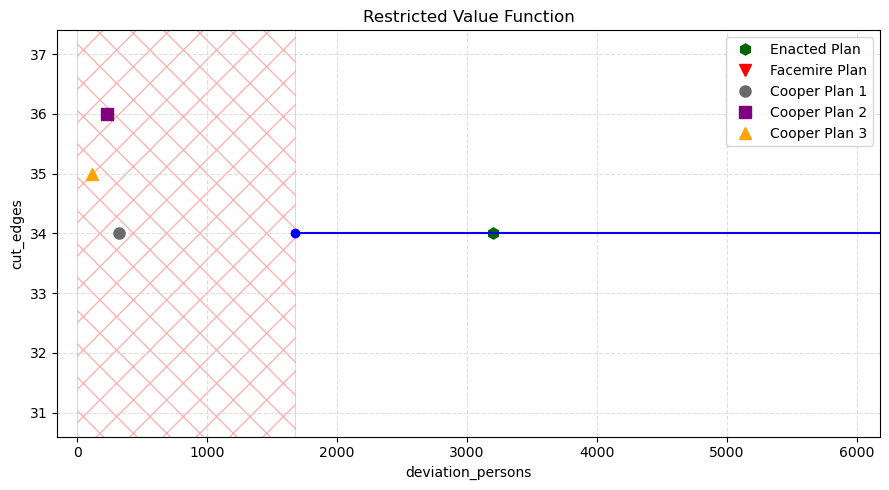

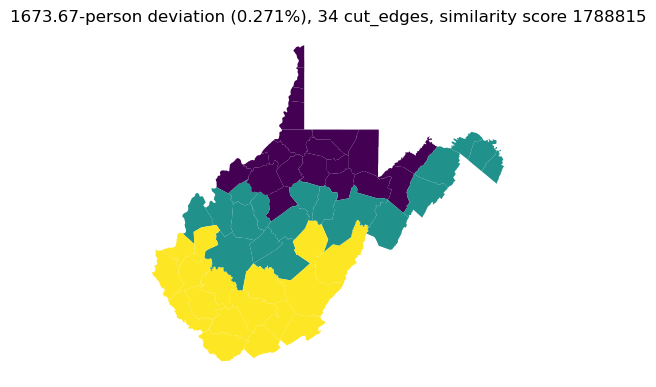

In [13]:
from pareto import plot_pareto_frontiers

epsilon = 1 / (2 * G._k)
for (state, obj_type), result in plans_dict.items():
    
    min_deviation = min(round(r[2], 1) for r in result)
    if min_deviation < epsilon:
        no_solution_region = None
    else:
        no_solution_region = [0, min_deviation]
        print(f"No feasible solution was found within the region: {no_solution_region}")
        
    plot_pareto_frontiers(
                    G,
                    method='epsilon_constraint_method',
                    plans=None,                                   #if method ='epsilon_constraint_method' is None 
                    obj_types=obj_type,                               
                    ideal_population=G._ideal_population,
                    state=state,
                    filepath=filepath,
                    filename2=filename2,
                    no_solution_region=no_solution_region,
                    year=year,
                    result=result,                               #if method ='heuristic' is None 
                    special_plans_scores=special_plans_scores,
                    similarity=[similarity_initial_districts,similarity_threshold]       
                 )